In [1]:
# Installation de l'environnement  
! sudo apt-get update
! sudo mkdir -p /usr/share/man/man1
! sudo apt-get install -y openjdk-11-jdk
! pip install --upgrade pip
! pip install pandas
! pip install pyspark
! pip install geopy

Get:1 http://security.debian.org/debian-security buster/updates InRelease [65.4 kB]
Get:2 http://deb.debian.org/debian buster InRelease [121 kB]
Get:3 http://deb.debian.org/debian buster-updates InRelease [51.9 kB]
Get:4 http://security.debian.org/debian-security buster/updates/main amd64 Packages [271 kB]
Get:5 http://deb.debian.org/debian buster/main amd64 Packages [7,907 kB]
Get:6 http://deb.debian.org/debian buster-updates/main amd64 Packages [9,504 B]
Fetched 8,426 kB in 2s (4,505 kB/s)




The following additional packages will be installed:
  at-spi2-core ca-certificates-java dbus dbus-user-session
  dconf-gsettings-backend dconf-service dmsetup fonts-dejavu-extra
  glib-networking glib-networking-common glib-networking-services
  gsettings-desktop-schemas java-common libapparmor1 libargon2-1 libasound2
  libasound2-data libatk-bridge2.0-0 libatk-wrapper-java
  libatk-wrapper-java-jni libatspi2.0-0 libcap2 libcolord2 libcryptsetup12
  libdconf1 libdevmapper1.02.1 libdrm-amdgpu1 

In [2]:
# Importation des bibliothèques à utiliser
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import pandas as pd

# create SparkSession
spark = SparkSession.builder.master("local[*]") \
                    .appName('SparkSNCF') \
                    .getOrCreate()

# extract SparkContext
sc = spark.sparkContext

print('Spark CPU usage :', sc.defaultParallelism)

Spark CPU usage : 2


In [3]:
#Importation et visualisation du dataFram
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, DoubleType
schema = StructType() \
      .add("origin",StringType(),True) \
      .add("destination",StringType(),True) \
      .add("price_2nd_eco",DoubleType(),True) \
      .add("price_2nd_full",DoubleType(),True) \
      .add("price_1",DoubleType(),True)
df = spark.read.option("header","true").schema(schema).option("delimiter", ";").csv("tarifs-intercites-100-eco.csv")
df.show()
df.printSchema()

+------------------+--------------------+-------------+--------------+-------+
|            origin|         destination|price_2nd_eco|price_2nd_full|price_1|
+------------------+--------------------+-------------+--------------+-------+
|  PARIS AUSTERLITZ|               BLOIS|         15.0|          29.4|   44.0|
|  PARIS AUSTERLITZ|          ST NAZAIRE|         15.0|          57.0|   86.0|
|       CHATEAUROUX|              CAHORS|         15.0|          50.0|   79.0|
|  PARIS AUSTERLITZ|MONTAUBAN VILLE B...|         15.0|          76.0|  115.0|
|       CHATEAUROUX|   TOULOUSE MATABIAU|         15.0|          63.0|   97.0|
|  PARIS AUSTERLITZ|             AMBOISE|         15.0|          33.2|   49.8|
|       LES AUBRAIS|             GOURDON|         15.0|          43.0|   65.0|
|  PARIS AUSTERLITZ|            POITIERS|         15.0|          47.9|   71.8|
|       CHATEAUROUX|            SOUILLAC|         15.0|          25.0|   38.0|
|        LE CROISIC| ST PIERRE DES CORPS|         15

In [4]:
# 1)Fonction et 4 résultats d'appels de la  fonction qui affiche le prix entre deux gares en premiere classe 

df.createOrReplaceTempView("SNCF_PRICE_DATA")

def itinaryPrice(gare1,gare2) :
    
    itinaryPrice = spark.sql(f"SELECT origin,destination,price_1 FROM SNCF_PRICE_DATA WHERE origin LIKE '%{gare1}%' AND destination LIKE '%{gare2}%'")
    itinaryPrice.show()
    

itinaryPrice("NANCY VILLE","SARREBOURG")
itinaryPrice("SAUMUR","LES AUBRAIS ORLEANS")
itinaryPrice("ANGOULEME","PARIS AUSTERLITZ")
itinaryPrice("LE CROISIC","PARIS AUSTERLITZ")


+-----------+-----------+-------+
|     origin|destination|price_1|
+-----------+-----------+-------+
|NANCY VILLE| SARREBOURG|   22.0|
+-----------+-----------+-------+

+------+-------------------+-------+
|origin|        destination|price_1|
+------+-------------------+-------+
|SAUMUR|LES AUBRAIS ORLEANS|   44.4|
+------+-------------------+-------+

+---------+----------------+-------+
|   origin|     destination|price_1|
+---------+----------------+-------+
|ANGOULEME|PARIS AUSTERLITZ|   89.3|
+---------+----------------+-------+

+----------+----------------+-------+
|    origin|     destination|price_1|
+----------+----------------+-------+
|LE CROISIC|PARIS AUSTERLITZ|   86.0|
+----------+----------------+-------+



In [5]:
# La fonction a été optimiser et affcihe none dans les deux cas spécifier par le tp 
df.createOrReplaceTempView("SNCF_PRICE_DATA")

def itinaryPrice(gare1,gare2) :

  try:
      itinaryPrice = spark.sql(f"SELECT origin,destination,price_1 FROM SNCF_PRICE_DATA WHERE origin LIKE '%{gare1}%' AND destination LIKE '%{gare2}%'")
      return itinaryPrice.collect()[0]["price_1"]
  except:
      return None

itinaryPrice("NANCY VILLE","SARREBOURG")

22.0

In [6]:
#2) Utilisation du module python geopy un classement descendant des distances pour chaque trajets possible

from geopy import distance
from geopy.geocoders import Nominatim
from pyspark.sql import functions as F
from pyspark.sql.functions import lit


def itinaryDistance(gare1,gare2) :
    geolocator = Nominatim(user_agent = "test")
    location1   = geolocator.geocode(f"{gare1}")
    location2   = geolocator.geocode(f"{gare2}")
    locationGare1 = (location1.longitude,location1.latitude)
    locationGare2 = (location2.longitude,location2.latitude)
    r= distance.distance(locationGare1, locationGare2).miles
    return r

#new_df = df.withColumn("Distance",lit(itinaryDistance("SAUMUR","LES AUBRAIS ORLEANS")))

itinary = spark.sql("SELECT origin,destination,price_1 FROM SNCF_PRICE_DATA")

tupleList = [(x["origin"], x["destination"],x["price_1"], itinaryDistance(x["origin"],x["destination"])) 
             for x in itinary.rdd.collect()]

tupleList = sorted(tupleList, key=lambda x: x[3],reverse=True)
for row in tupleList:
    print("La distance de {} a {} est de : {}".format(
        row[0],
        row[1],
        row[3]))


La distance de LES AUBRAIS a GOURDON est de : 415.23076092278967
La distance de STRASBOURG a PARIS EST est de : 371.0164259151755
La distance de PARIS AUSTERLITZ a TOULOUSE MATABIAU est de : 366.9381936802106
La distance de LE CROISIC a PARIS AUSTERLITZ est de : 351.68985931756094
La distance de LA BAULE ESCOUBLAC a PARIS AUSTERLITZ est de : 344.4135631192787
La distance de PARIS EST a SAVERNE est de : 343.9228690238673
La distance de BORDEAUX ST JEAN a PARIS AUSTERLITZ est de : 342.6666118823836
La distance de PARIS AUSTERLITZ a MONTAUBAN VILLE BOURBON est de : 341.0590737069184
La distance de PARIS AUSTERLITZ a ST NAZAIRE est de : 332.8538831600457
La distance de LES AUBRAIS a SOUILLAC est de : 331.4085839029465
La distance de PARIS EST a SARREBOURG est de : 322.86016294180547
La distance de PARIS AUSTERLITZ a CAHORS est de : 310.2599755730477
La distance de LE CROISIC a LES AUBRAIS ORLEANS est de : 306.54171408298254
La distance de LES AUBRAIS ORLEANS a TOULOUSE MATABIAU est de : 29

In [7]:
#3) Créer un Dataframe listant tous les trajets possibles avec 3 colonnes : Trajet, Distance, Prix en 1ère classe

data = sc.parallelize(tupleList)

data_converted = data.map(lambda x: (x[0], x[1], x[2],x[3]))

schema = StructType([
    StructField("Origin", StringType(), True),
    StructField("Destination", StringType(), True),
    StructField("Price_1", DoubleType(), True),
    StructField("Distance", DoubleType(), True)
])

DF = spark.createDataFrame(data_converted, schema)
DF.show()

+-------------------+--------------------+-------+------------------+
|             Origin|         Destination|Price_1|          Distance|
+-------------------+--------------------+-------+------------------+
|        LES AUBRAIS|             GOURDON|   65.0|415.23076092278967|
|         STRASBOURG|           PARIS EST|   96.0| 371.0164259151755|
|   PARIS AUSTERLITZ|   TOULOUSE MATABIAU|  115.0| 366.9381936802106|
|         LE CROISIC|    PARIS AUSTERLITZ|   86.0|351.68985931756094|
| LA BAULE ESCOUBLAC|    PARIS AUSTERLITZ|   86.0| 344.4135631192787|
|          PARIS EST|             SAVERNE|   91.0| 343.9228690238673|
|   BORDEAUX ST JEAN|    PARIS AUSTERLITZ|  108.0| 342.6666118823836|
|   PARIS AUSTERLITZ|MONTAUBAN VILLE B...|  115.0| 341.0590737069184|
|   PARIS AUSTERLITZ|          ST NAZAIRE|   86.0| 332.8538831600457|
|        LES AUBRAIS|            SOUILLAC|   85.0| 331.4085839029465|
|          PARIS EST|          SARREBOURG|   87.0|322.86016294180547|
|   PARIS AUSTERLITZ

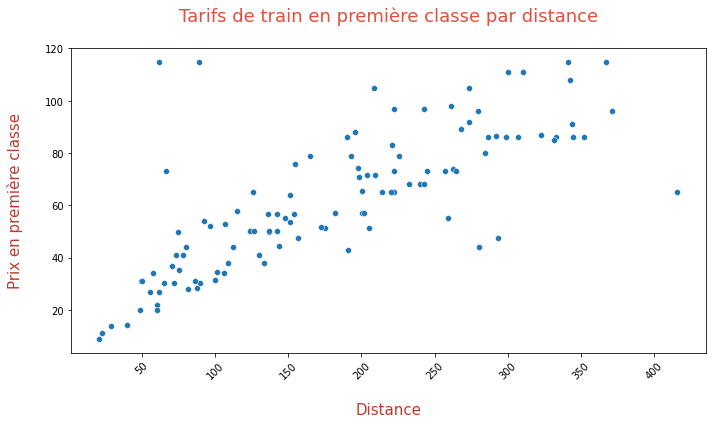

In [11]:
# 4. Créer une représentation graphique mettant en avant la corrélation entre le prix et la distance pour chaque trajet possible

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

P_List = [(x["price_1"]) 
            for x in itinary.rdd.collect()]
D_List = [(itinaryDistance(x["origin"],x["destination"])) 
            for x in itinary.rdd.collect()]
plt.figure(figsize=(10,6))
sns.scatterplot(x=D_List,y=P_List,palette='Reds_r')
plt.xlabel('\nDistance', fontsize=15, color='#c0392b')
plt.ylabel("Prix en première classe\n", fontsize=15, color='#c0392b')
plt.title("Tarifs de train en première classe par distance\n", fontsize=18, color='#e74c3c')
plt.xticks(rotation= 45)
plt.tight_layout()


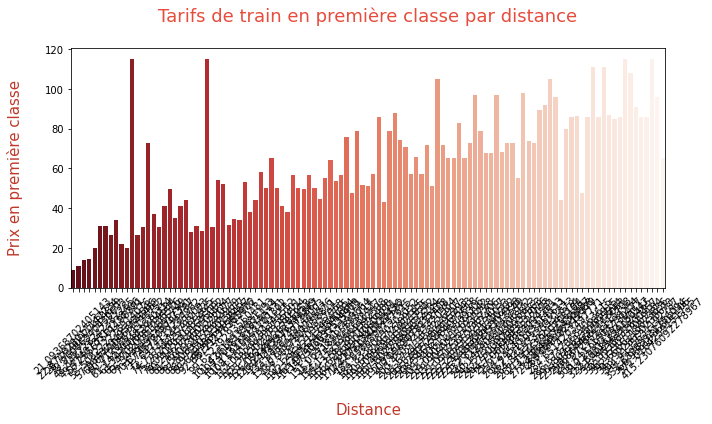

In [12]:
plt.figure(figsize=(10,6))
sns.barplot(x=D_List,y=P_List,palette='Reds_r')
plt.xlabel('\nDistance', fontsize=15, color='#c0392b')
plt.ylabel("Prix en première classe\n", fontsize=15, color='#c0392b')
plt.title("Tarifs de train en première classe par distance\n", fontsize=18, color='#e74c3c')
plt.xticks(rotation= 45)
plt.tight_layout()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=aadf8a63-34d5-4fc9-8006-58d3e1062c05' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>